In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.decomposition import FactorAnalysis

# regression algorithms
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('insurance.csv')

In [2]:
# Remove target variable from dataset
y = data['insurance_cost']
X = data.drop('insurance_cost', axis=1)

In [3]:
# Split Dataset into train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13)

In [4]:
# Variable Transformation & Encoding Pipeline
# Gender, Children, Smoker, Region and Insurance_cost_binary are all categorical variables
categorical_variables = ['gender','children','smoker','region']
transform_category = Pipeline(steps = [
    ('onehotencode',OneHotEncoder(handle_unknown='ignore'))
    ])
# BMI Variable Transform:
bmi_variable = ['bmi']
transform_bmi = Pipeline(steps = [
    ('standard_scaler', StandardScaler())
    ])

# Age Variable Transform
age_variable = ['age']
transform_age = Pipeline(steps = [
    ("log_transform", FunctionTransformer(np.log)),
    ('standard_scaler', StandardScaler())
    ])

# Preprocessing Pipeline
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("categorical", transform_category, categorical_variables),
        ("bmi", transform_bmi, bmi_variable),
        ("age", transform_age, age_variable),
    ],
    remainder='passthrough'
)

In [5]:
# Random Forest Regression:
pipe = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('transformed_tr', TransformedTargetRegressor(
    regressor = RandomForestRegressor(n_estimators=10),
    func=np.log,
    inverse_func=np.exp))
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'children',
                                                   'smoker', 'region']),
                                                 ('bmi',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('reduce_dim', 'passthrough'),
                ('transformed_tr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=10)))])

In [6]:
n_features = [2,4,6,8]
max_depth = [2,4,6,8]
criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']

parameter_grid = [
    {
        'reduce_dim': [PCA(iterated_power=5)],
        'reduce_dim__n_components': n_features,
        'transformed_tr__regressor__max_depth': max_depth,
        'transformed_tr__regressor__criterion': criterion
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': n_features,
        'transformed_tr__regressor__max_depth': max_depth,
        'transformed_tr__regressor__criterion': criterion
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': n_features,
        'transformed_tr__regressor__max_depth': max_depth,
        'transformed_tr__regressor__criterion': criterion
    }
    
]
    
# Prepare and fit model
random_forest_search = GridSearchCV(pipe, parameter_grid, n_jobs=-1, cv=5, refit=True)
random_forest_search.fit(X_train,y_train)

random_forest_best_model = random_forest_search.best_estimator_
random_forest_best_paramters = random_forest_search.best_params_

# Results
print("The best Random Forest Model score was: ", random_forest_search.best_score_)
print("The best Random Forest Model parameters were: ", random_forest_search.best_params_)

The best Random Forest Model score was:  0.8664905343677457
The best Random Forest Model parameters were:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'transformed_tr__regressor__criterion': 'friedman_mse', 'transformed_tr__regressor__max_depth': 4}


In [7]:
# Linear Regression
pipe = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('transformed_tr', TransformedTargetRegressor(
    regressor = LinearRegression(),
    func=np.log,
    inverse_func=np.exp))
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'children',
                                                   'smoker', 'region']),
                                                 ('bmi',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('reduce_dim', 'passthrough'),
                ('transformed_tr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [8]:
n_features = [2,4,6,8]
fit_intercept = [True, False]

parameter_grid = [
    {
        'reduce_dim': [PCA(iterated_power=5)],
        'reduce_dim__n_components': n_features,
        'transformed_tr__regressor__fit_intercept': fit_intercept
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': n_features,
        'transformed_tr__regressor__fit_intercept': fit_intercept
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': n_features,
        'transformed_tr__regressor__fit_intercept': fit_intercept
    }
    
]
    
# Prepare and fit model
linear_regression_search = GridSearchCV(pipe, parameter_grid, n_jobs=-1, cv=5, refit=True)
linear_regression_search.fit(X_train,y_train)

linear_regression_best_model = linear_regression_search.best_estimator_
linear_regression_best_paramters = linear_regression_search.best_params_

# Results
print("The best Linear Regression Model score was: ", linear_regression_search.best_score_)
print("The best Linear Regression Model parameters were: ", linear_regression_search.best_params_)

The best Linear Regression Model score was:  0.6024512772983094
The best Linear Regression Model parameters were:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'transformed_tr__regressor__fit_intercept': True}


In [9]:
# K Nearest Neighbour Regression
pipe = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('transformed_tr', TransformedTargetRegressor(
    regressor = KNeighborsRegressor(),
    func=np.log,
    inverse_func=np.exp))
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'children',
                                                   'smoker', 'region']),
                                                 ('bmi',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('reduce_dim', 'passthrough'),
                ('transformed_tr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=KNeighborsRegressor()))])

In [10]:
n_features = [2,4,6,8]
n_neighbors = [2,3,4,5]
weights = ['uniform', 'distance']
algorithm = ['auto','ball_tree','kd_tree']
parameter_grid = [
    {
        'reduce_dim': [PCA(iterated_power=5)],
        'reduce_dim__n_components': n_features,
        'transformed_tr__regressor__n_neighbors': n_neighbors,
        'transformed_tr__regressor__weights': weights,
        'transformed_tr__regressor__algorithm': algorithm
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': n_features,
        'transformed_tr__regressor__n_neighbors': n_neighbors,
        'transformed_tr__regressor__weights': weights,
        'transformed_tr__regressor__algorithm': algorithm
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': n_features,
        'transformed_tr__regressor__n_neighbors': n_neighbors,
        'transformed_tr__regressor__weights': weights,
        'transformed_tr__regressor__algorithm': algorithm
    }
    
]
    
# Prepare and fit model
KNN_regression_search = GridSearchCV(pipe, parameter_grid, n_jobs=-1, cv=5, refit=True)
KNN_regression_search.fit(X_train,y_train)

KNN_regression_best_model = KNN_regression_search.best_estimator_
KNN_regression_best_paramters = KNN_regression_search.best_params_

# Results
print("The best KNN Regression Model score was: ", KNN_regression_search.best_score_)
print("The best KNN Regression Model parameters were: ", KNN_regression_search.best_params_)

The best KNN Regression Model score was:  0.8426398783328347
The best KNN Regression Model parameters were:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'transformed_tr__regressor__algorithm': 'ball_tree', 'transformed_tr__regressor__n_neighbors': 5, 'transformed_tr__regressor__weights': 'uniform'}


In [30]:
def evaluate_model(X_test, y_test, model):
    ''' Evaluate performance of regression models'''
    _predicted_values = model.predict(X_test)
    mse = mean_squared_error(y_test, _predicted_values)
    mae = mean_absolute_error(y_test, _predicted_values)
    r2 = r2_score(y_test, _predicted_values)
    
    return mse, mae, r2

In [31]:
random_forest_mse, random_forest_mae, random_forest_r2 = evaluate_model(X_test, y_test, random_forest_best_model)
linear_regression_mse, linear_regression_mae, linear_regression_r2 = evaluate_model(X_test, y_test, linear_regression_best_model)
knn_mse, knn_mae, knn_r2 = evaluate_model(X_test, y_test, KNN_regression_best_model)

In [58]:
# Plot Regression Model Metrics
models = ['Random Forest', 'Linear Regression', 'KNN']
mse_compare = [random_forest_mse, linear_regression_mse, knn_mse]
mae_compare = [random_forest_mae, linear_regression_mae, knn_mae]
r2_compare = [random_forest_r2, linear_regression_r2,knn_r2]
colors = ['blue','orange','green']

def plot_metrics(data, title,ylabel, colors):
    ''' Visualise Regression Model Metrics'''
    plt.figure(figsize=(15,10))
    bar = plt.bar(models, data, color=colors)
    plt.legend(bar, models, loc="upper right")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

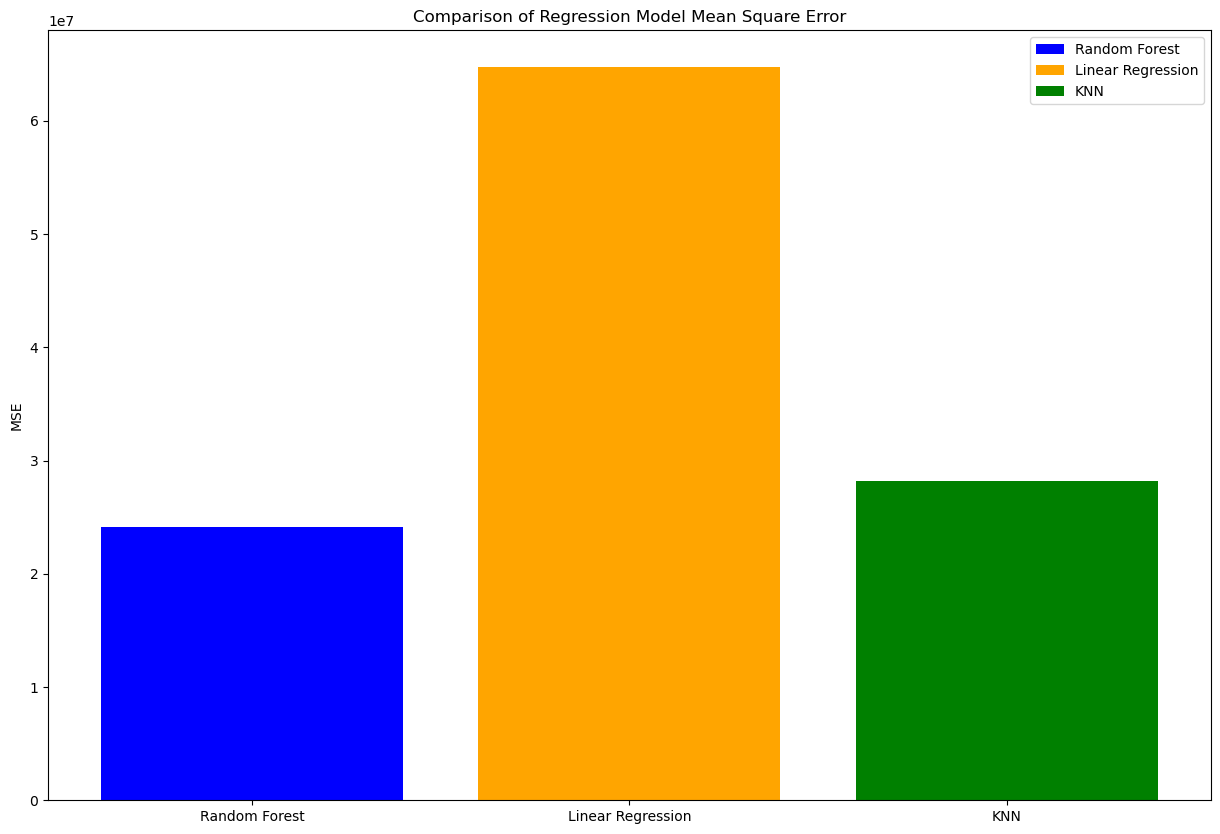

In [59]:
# Mean Square Error:
plot_metrics(mse_compare,"Comparison of Regression Model Mean Square Error", "MSE", colors)

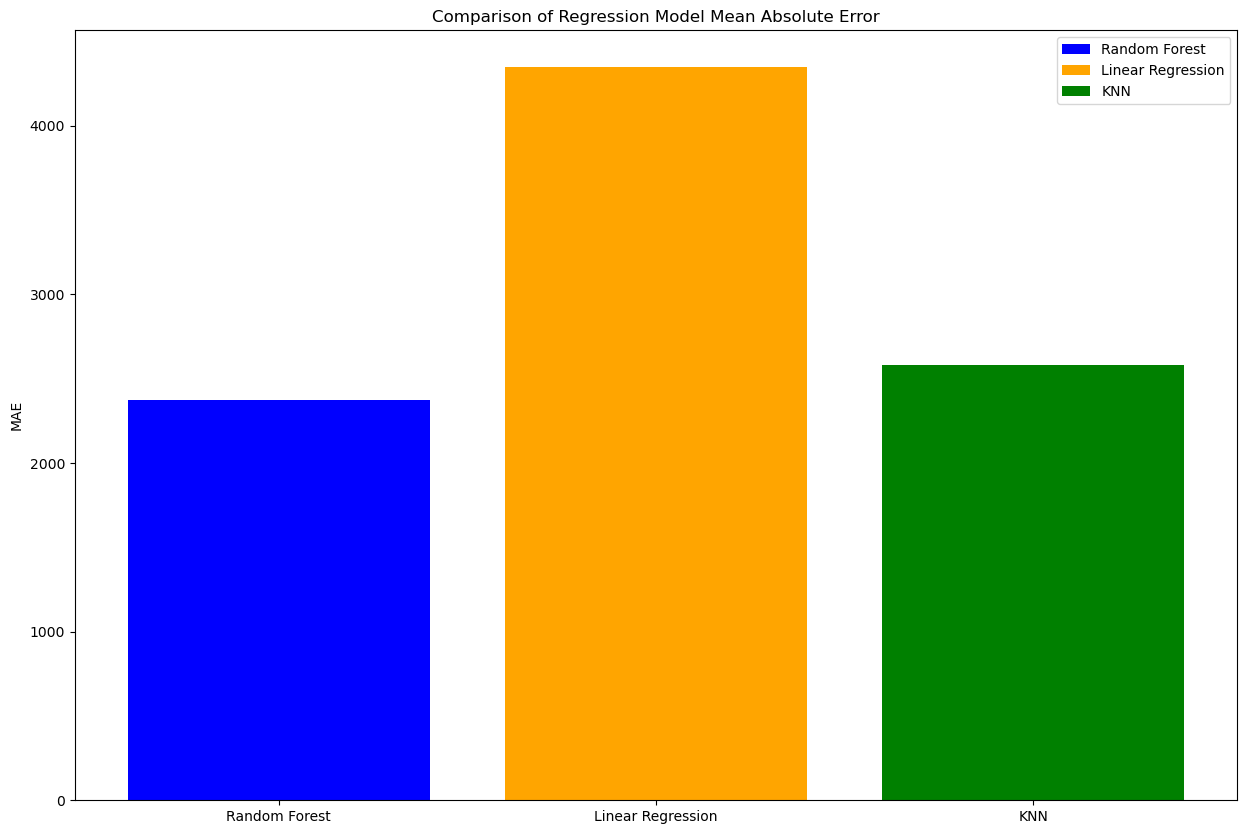

In [61]:
# Mean Absolute Error:
plot_metrics(mae_compare,"Comparison of Regression Model Mean Absolute Error","MAE", colors)

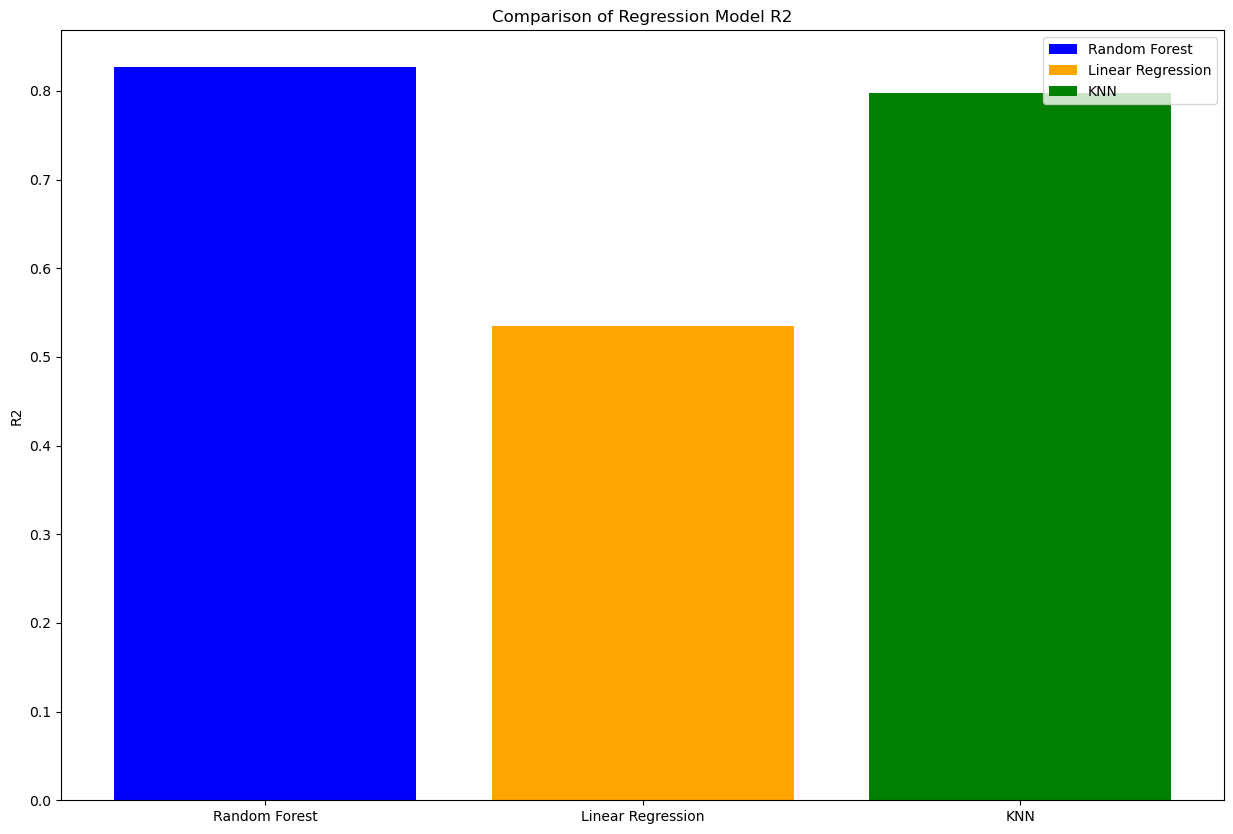

In [60]:
# R2:
plot_metrics(r2_compare,"Comparison of Regression Model R2","R2", colors)